In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r drive/MyDrive/Programming/ml_project/models* ./
!cp drive/MyDrive/Programming/ml_project/shoes_iter1_2.hdf5 ./
!cp drive/MyDrive/Programming/ml_project/handbag_64.hdf5 ./

In [ ]:
!cp -r drive/MyDrive/Programming/ml_project/models/* ./

In [ ]:
!pip install pot
!pip install wanb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement wanb (from versions: none)
ERROR: No matching distribution found for wanb


In [ ]:
import os, sys
sys.path.append("..")
sys.path.append('.')

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.unet import UNet

from src.tools import unfreeze, freeze
from src.tools import weights_init_D
from src.tools import load_dataset, get_pushed_loader_stats
from src.tools import load_dataset, get_loader_stats
from src.fid_score import calculate_frechet_distance
from src.plotters import plot_random_images, plot_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

from src.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

ModuleNotFoundError: ignored

# Compute Stats

Запустить эту секцию только один раз. После этого будут созданы два файла для, которые будут использованы позже. Перезапустить ноутбук после выполнения секции т.к. не хватит оперативной памяти. Btw, ноутбук ест около 18-20 гигов оперативы

In [ ]:
DEVICE_ID = 0

DATASET_LIST = [
    #('shoes', './shoes_64.hdf5', 64),
    ('handbag', './handbag_64.hdf5', 64)
    ]

assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_ID}')


In [ ]:
DATASET_LIST

[('handbag', './handbag_64.hdf5', 64)]

In [ ]:
for DATASET, DATASET_PATH, IMG_SIZE in tqdm(DATASET_LIST):
    print('Processing {}'.format(DATASET))
    sampler, test_sampler = load_dataset(DATASET, DATASET_PATH, img_size=IMG_SIZE)
    print('Dataset {} loaded'.format(DATASET))

    mu, sigma = get_loader_stats(test_sampler.loader)
    print('Trace of sigma: {}'.format(np.trace(sigma)))
    stats = {'mu' : mu.tolist(), 'sigma' : sigma.tolist()}
    print('Stats computed')

    filename = '{}_{}_test.json'.format(DATASET, IMG_SIZE)
    with open(filename, 'w') as fp:
        json.dump(stats, fp)
    print('States saved to {}'.format(filename))



<ipython-input-13-e59e9c17d417>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for DATASET, DATASET_PATH, IMG_SIZE in tqdm(DATASET_LIST):


  0%|          | 0/1 [00:00<?, ?it/s]

Processing handbag
Keys: <KeysViewHDF5 ['imgs']>


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Dataset handbag loaded


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

Trace of sigma: 141.89924385238442
Stats computed
States saved to handbag_64_test.json


In [ ]:
!cp handbag_64_test.json ./stats/
#!cp shoes_64_test.json ./stats/

# Models and datasets load 

In [ ]:
DEVICE_IDS = [0]

DATASET1, DATASET1_PATH = 'shoes', './shoes_iter1_2.hdf5'
#DATASET1, DATASET1_PATH = 'shoes', './shoes_64.hdf5'
DATASET2, DATASET2_PATH = 'handbag', './handbag_64.hdf5'

# DATASET1, DATASET1_PATH = 'celeba_female', '../../data/img_align_celeba'
# DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../data/aligned_anime_faces'

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 64

BATCH_SIZE = 128

PLOT_INTERVAL = 100
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 500
MAX_STEPS = 100001
SEED = 0x000000

EXP_NAME = f'{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}'
OUTPUT_PATH = '../checkpoints/{}/{}_{}_{}/'.format(COST, DATASET1, DATASET2, IMG_SIZE)

In [ ]:
config = dict(
    DATASET1=DATASET1,
    DATASET2=DATASET2, 
    T_ITERS=T_ITERS,
    f_LR=f_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [ ]:
filename = './stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

In [ ]:
X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH, img_size=IMG_SIZE, batch_size=64)
Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE, batch_size=64)
    
torch.cuda.empty_cache(); gc.collect()
# clear_output()

Keys: <KeysViewHDF5 ['shoes_iter1']>


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Keys: <KeysViewHDF5 ['imgs']>


76

In [ ]:
f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3, base_factor=48).cuda()

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 9715827
f params: 22933441


In [ ]:
TO_SAVE = True
SAVE_NAME = '9999_1'
if TO_SAVE:
    T.load_state_dict(torch.load('./T_0_' + SAVE_NAME + '.pt'))
    f.load_state_dict(torch.load('./f_0_' + SAVE_NAME + '.pt'))

In [ ]:
mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader)
fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)

In [ ]:
fid

37.86851618287017

In [ ]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)
X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

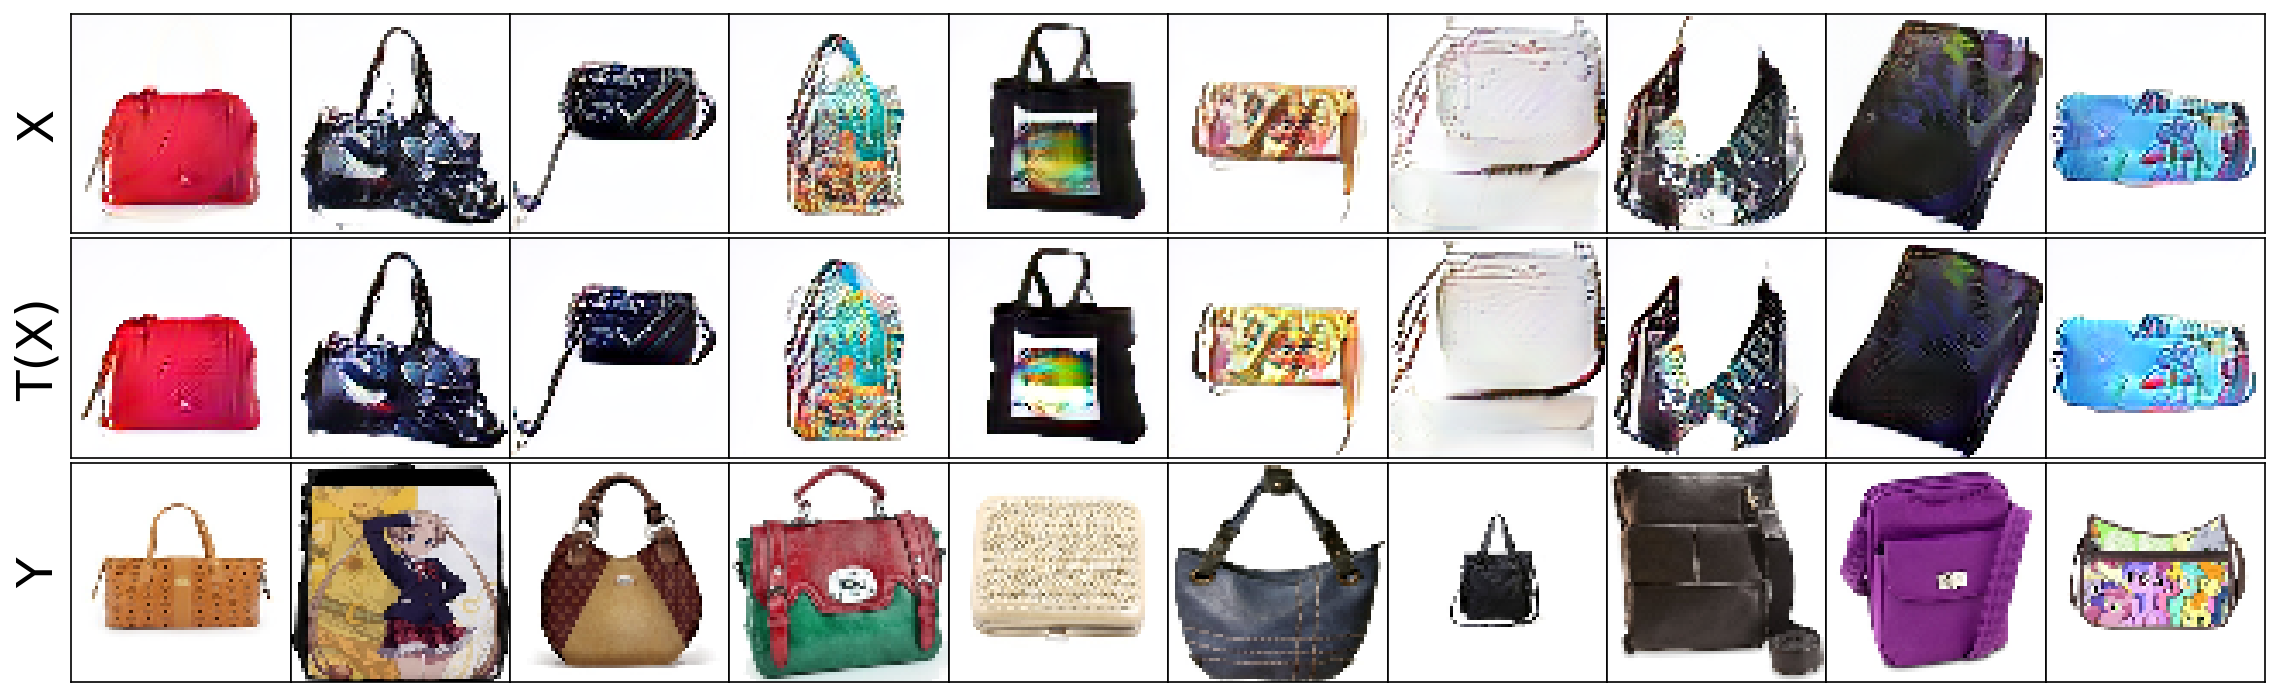

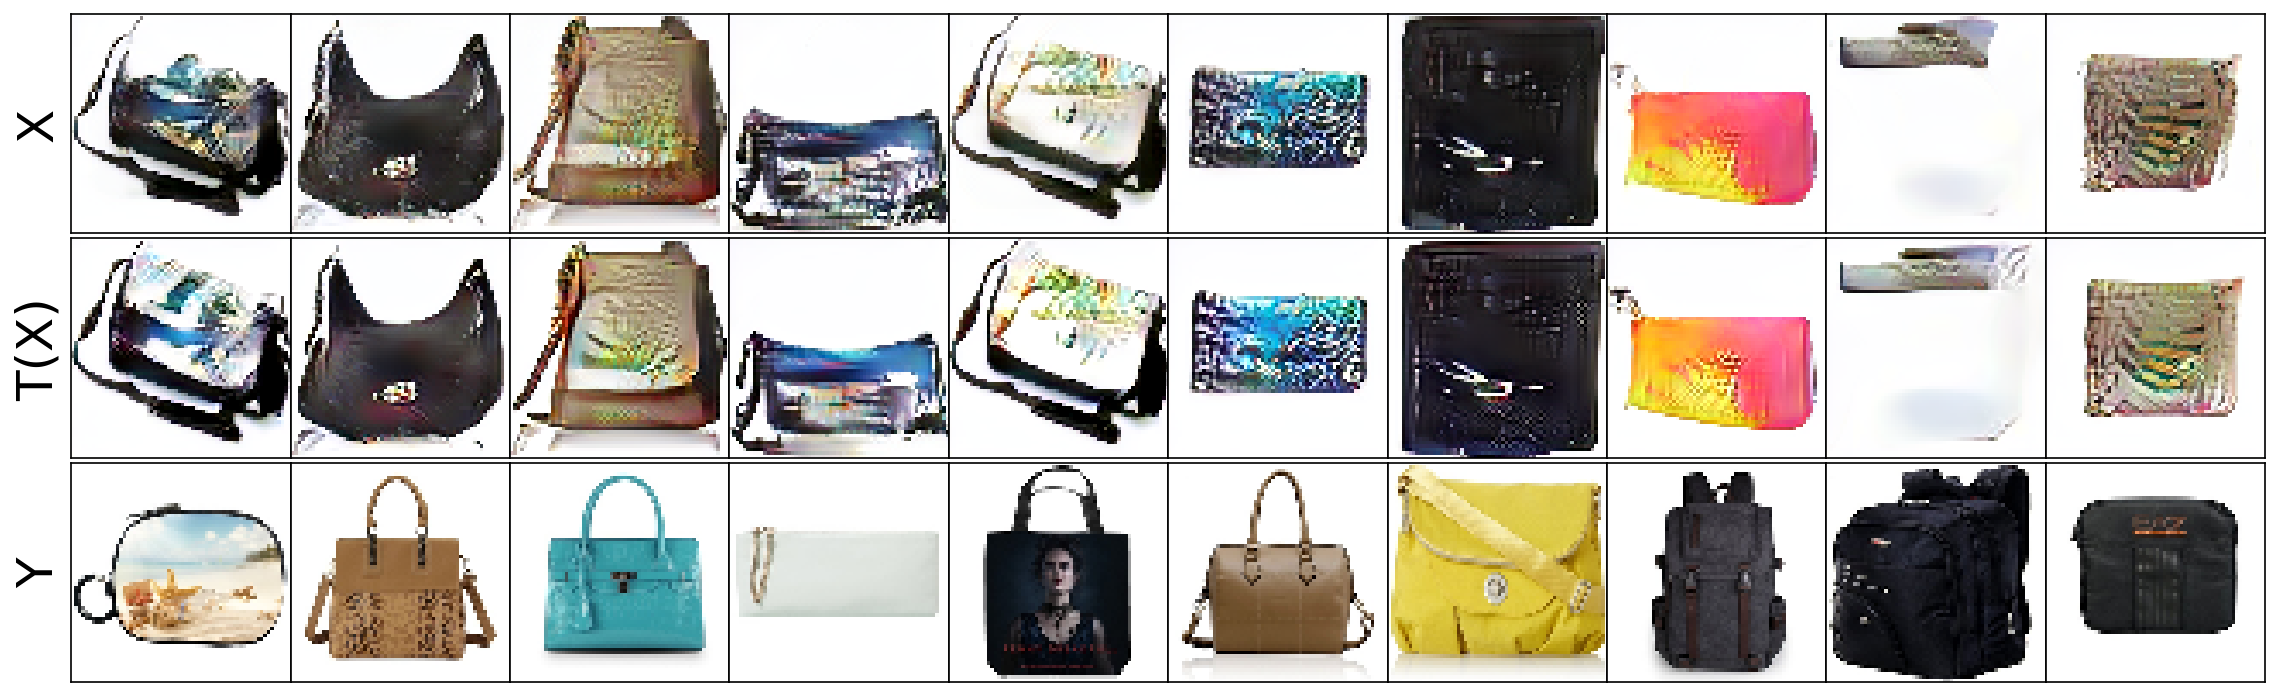

In [ ]:
freeze(T)
fig, axes = plot_images(T1(T(X_fixed)), Y_fixed, T2)
#fig, axes = plot_random_images(X_sampler, Y_sampler, T)
fig, axes = plot_images(T1(T(X_test_fixed)), Y_test_fixed, T2)
#fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)

# Mapping NN on dataset


In [ ]:
def sampler_to_hdf5(X_sampler, T, save_dir, BATCH_SIZE=64, num_imgs=45000):
    '''
    X_sampler - sampler with loaded images
    T - trained nn
    save_dir - directory where hdf5 file would be saved
    BATCH_SIZE - batch size which was provided to T
    num_imgs - expected number of images  
    '''
    loader = X_sampler.loader
    n_iters = len(loader)
    n_image=0
    h5_file = h5py.File(save_dir)
    data = h5_file.create_dataset('imgs', shape=(num_imgs, 64, 64 3), dtype=np.int64)
    freeze(T)
    for iter in range(n_iters):
        x = X_sampler.sample(BATCH_SIZE)
        T_x = T(x)
        imgs = (T_x.to('cpu').permute(0, 2, 3, 1).mul(0.5).add(0.5).numpy().clip(0, 1) * 255).astype(np.int64)
        for img in imgs:
            data[n_image] = img
            n_image+=1
            if (n_image) == num_imgs:
                break
    if n_image < num_imgs - 1:
        print(f'Warinig something wrong with batch size. Amount of pictures is less than {num_images}')
    h5_file.close()

SyntaxError: ignored

In [ ]:
len(X_sampler.loader)*64
BATCH_SIZE

128

In [ ]:
import h5py
loader = X_sampler.loader
n_iters = len(loader)
n_image = 0
BATCH_SIZE=64
h5_file = h5py.File('./shoes_iter2.hdf5', 'w')
data = h5_file.create_dataset('shoes_iter2', shape=(40512, 64, 64, 3), dtype=np.int64)
freeze(T)
for iter in range(n_iters):
        x = X_sampler.sample(BATCH_SIZE)
        T_x = T(x)
        imgs = (T_x.to('cpu').permute(0, 2, 3, 1).mul(0.5).add(0.5).numpy().clip(0, 1) * 255).astype(np.int64)
        if (imgs == -1).any():
            break
        for img in imgs:
            data[n_image] = img
            n_image+=1
            if (n_image) == 40512:
                break
h5_file.close()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Training of the model

In [ ]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

In [ ]:
# Run this cell if you want to download f_opt and T_opt
# Setup to_load = True
# Setup iter num to saved iteration number
TO_SAVE = True
ITER_NUM = 499
SAVE_NAME = '9999_1'
if TO_SAVE:
    T_opt.load_state_dict(torch.load('./T_opt_0_' + SAVE_NAME + '.pt'))
    f_opt.load_state_dict(torch.load('./f_opt_0_' + SAVE_NAME + '.pt'))

In [ ]:
save_dir = 'drive/MyDrive/Programming/ml_project/models/'

In [ ]:
BATCH_SIZE=64
ITER_NUM=0
model_num = 2
CPKT_INTERVAL=1000
fid = []

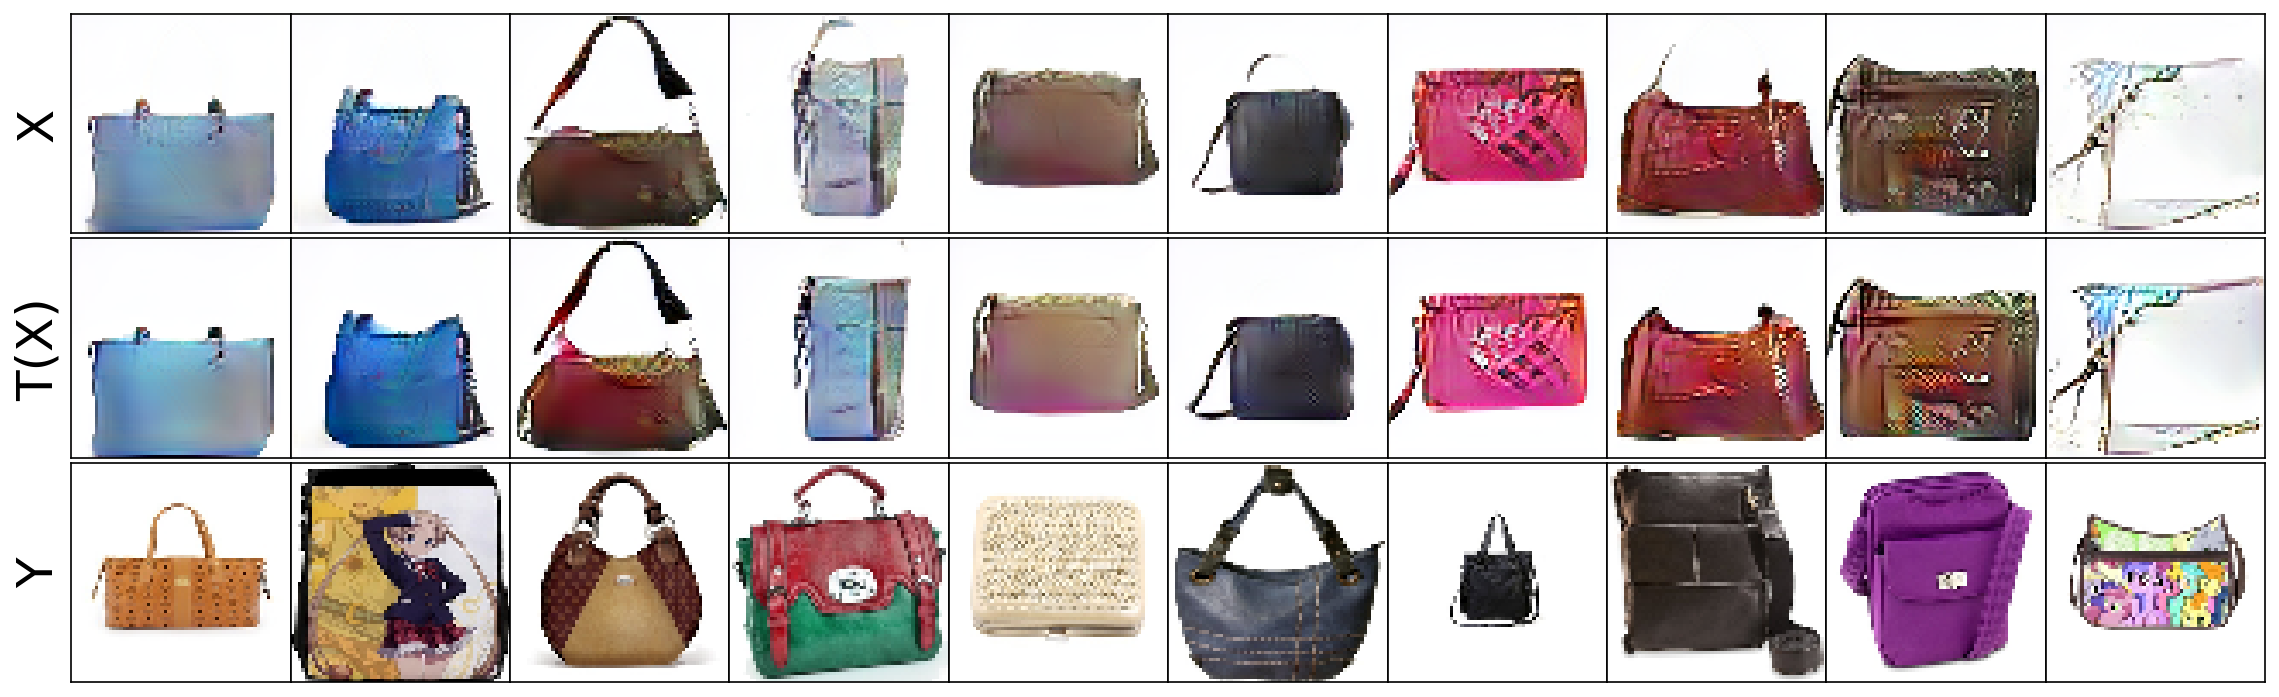

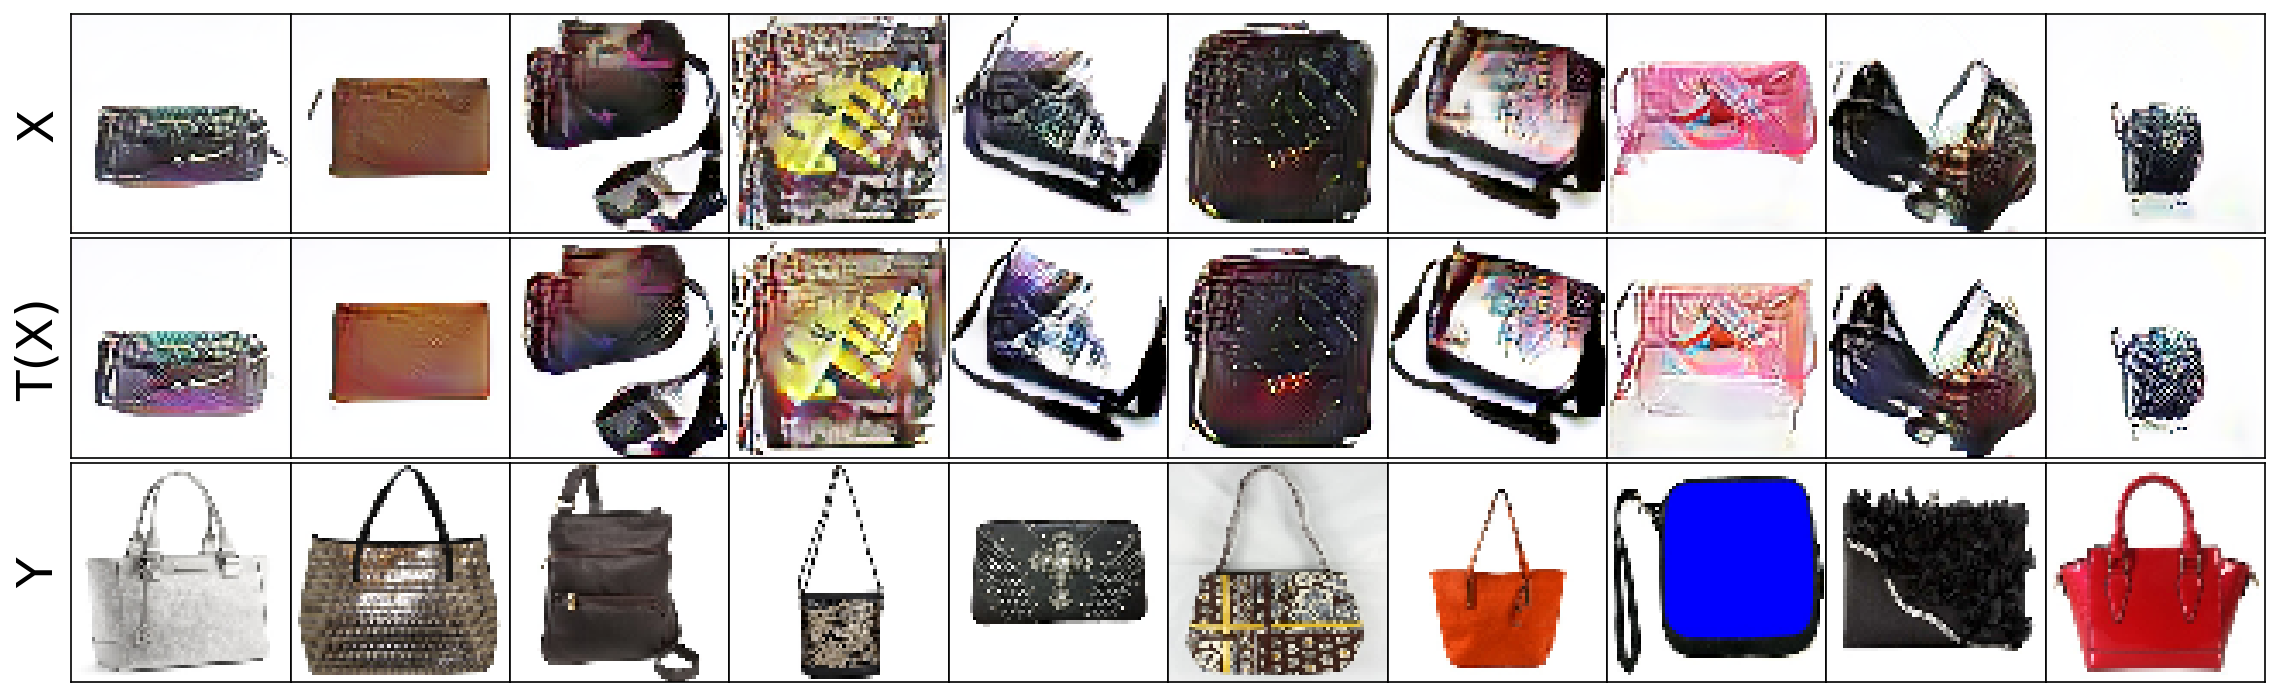

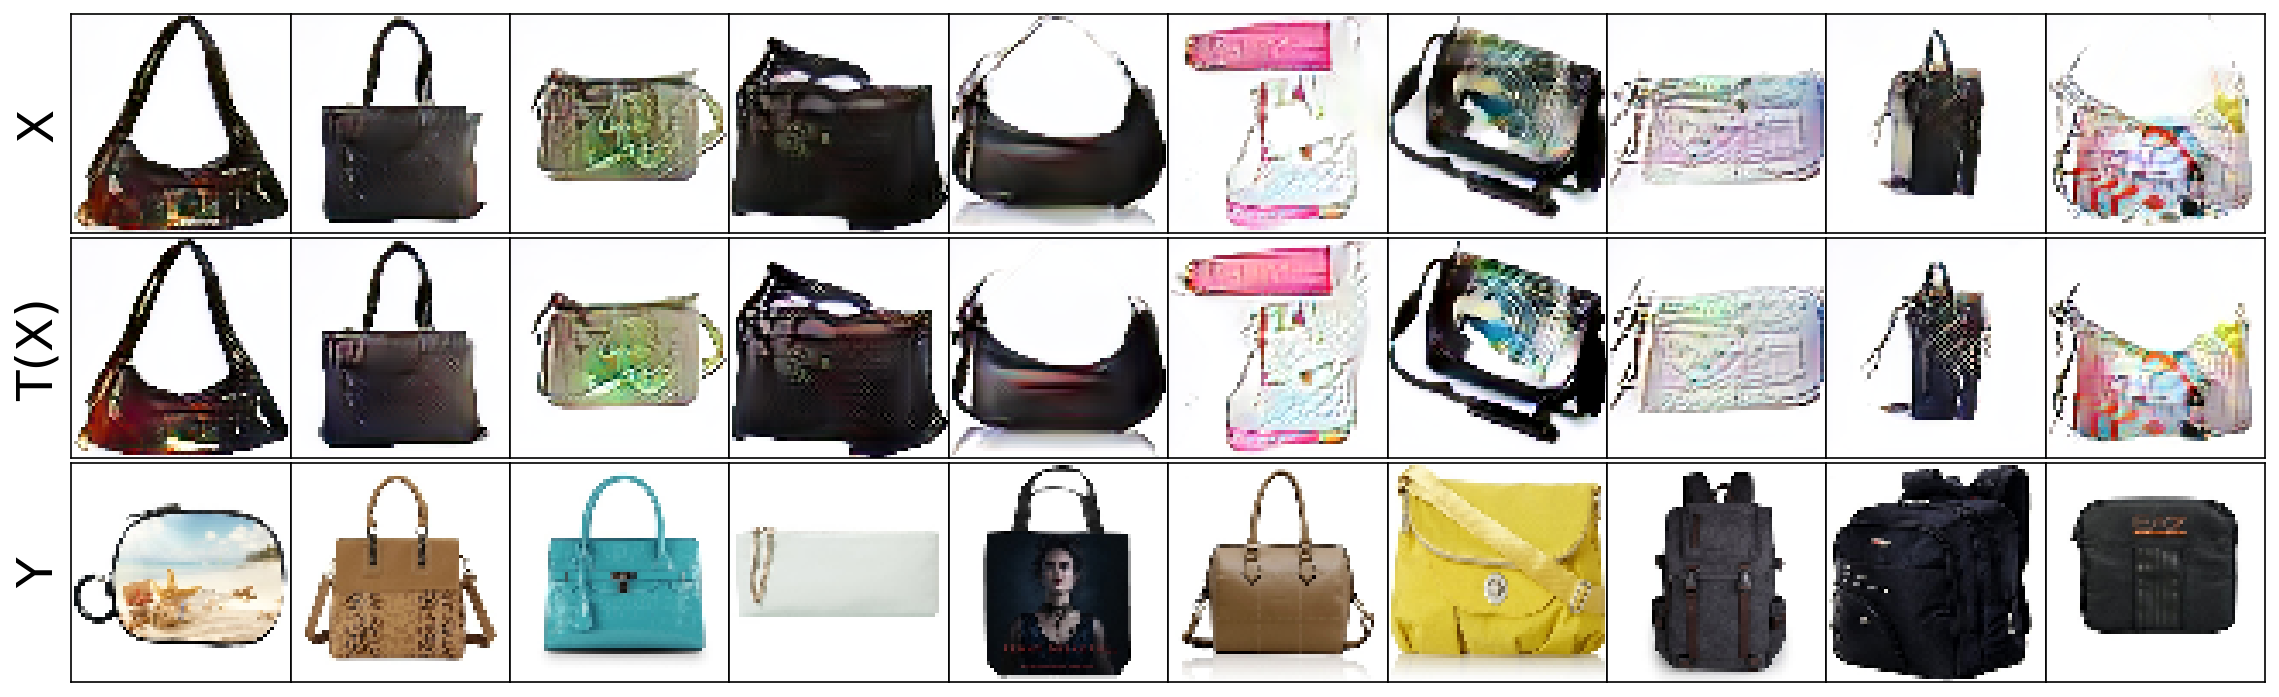

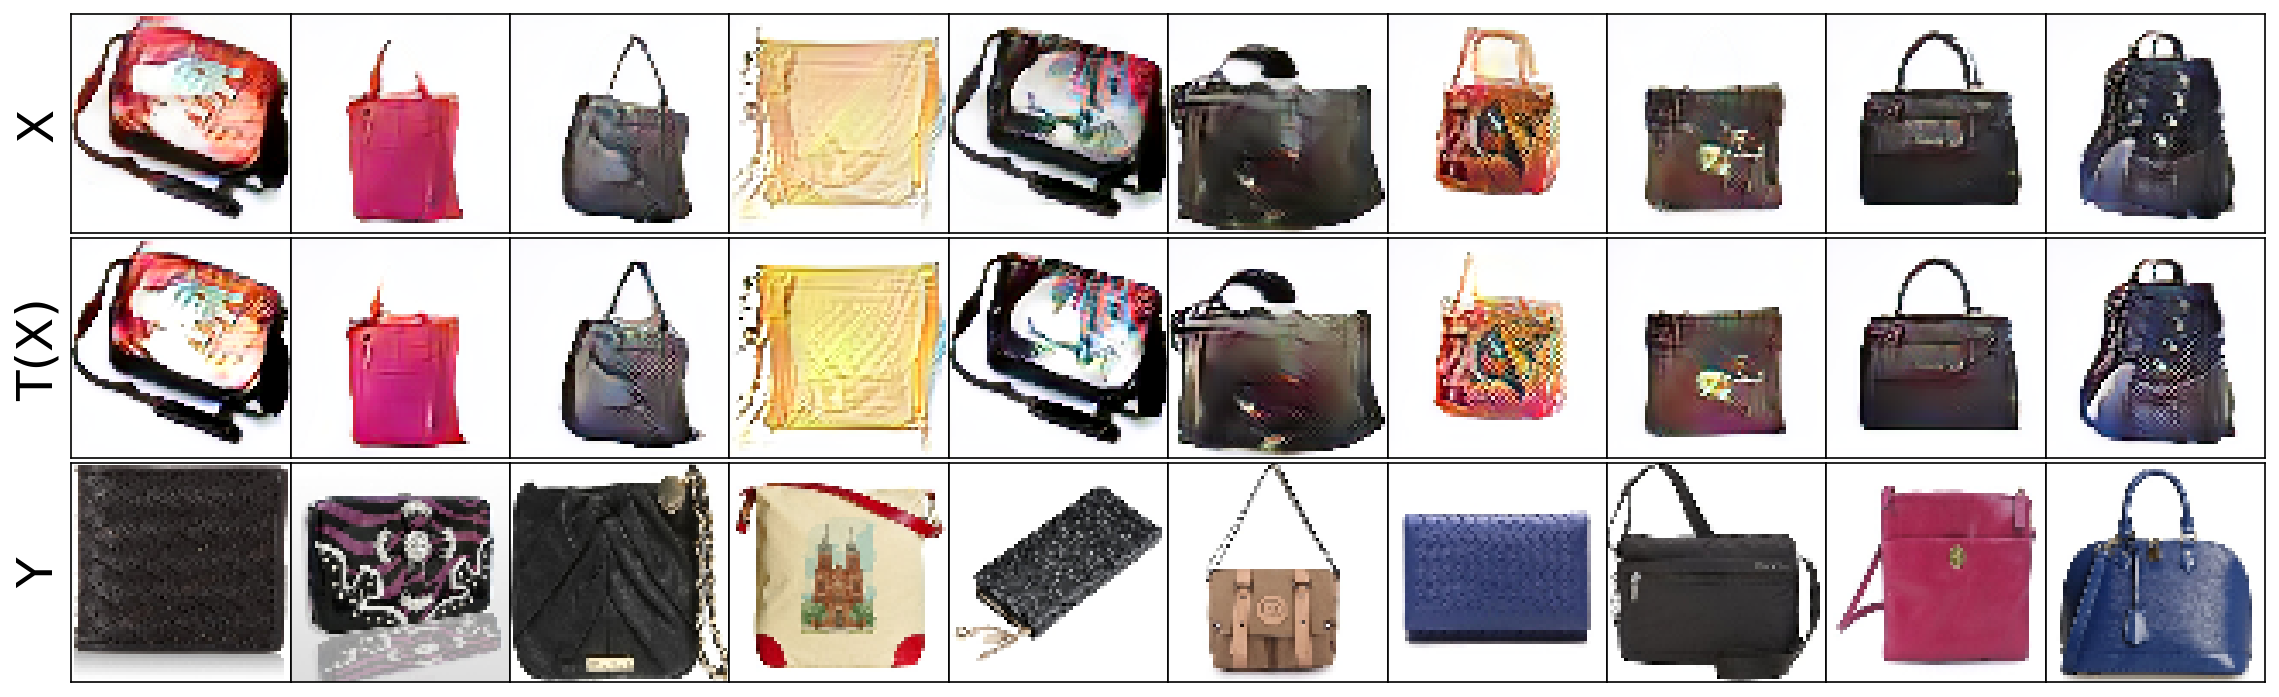

{'f_loss': 0.1344860941171646} 5001
{'f_loss': 0.12616854906082153} 5002
{'f_loss': 0.05542762577533722} 5003
{'f_loss': 0.062605120241642} 5004
{'f_loss': 0.06628285348415375} 5005
{'f_loss': 0.08840853720903397} 5006
{'f_loss': 0.0825265645980835} 5007
{'f_loss': 0.0877944752573967} 5008
{'f_loss': 0.06656655669212341} 5009
{'f_loss': 0.08163827657699585} 5010
{'f_loss': 0.13844625651836395} 5011
{'f_loss': 0.15924353897571564} 5012
{'f_loss': 0.10127820074558258} 5013
{'f_loss': 0.12619143724441528} 5014
{'f_loss': 0.08104532957077026} 5015
{'f_loss': 0.12248556315898895} 5016
{'f_loss': 0.06340914964675903} 5017
{'f_loss': 0.11324109137058258} 5018
{'f_loss': 0.09133373200893402} 5019
{'f_loss': 0.1012599840760231} 5020
{'f_loss': 0.07222243398427963} 5021
{'f_loss': 0.10429662466049194} 5022
{'f_loss': 0.14976772665977478} 5023
{'f_loss': 0.17558377981185913} 5024
{'f_loss': 0.14114412665367126} 5025
{'f_loss': 0.10819149017333984} 5026
{'f_loss': 0.08827893435955048} 5027
{'f_los

KeyboardInterrupt: ignored

In [ ]:
for step in tqdm(range(ITER_NUM, MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS): 
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)
        T_X = T(X)
        if COST == 'mse':
            T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean()
        else:
            raise Exception('Unknown COST')
        T_loss.backward(); T_opt.step()
    del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        T_X = T(X)
    Y = Y_sampler.sample(BATCH_SIZE)
    f_opt.zero_grad()
    f_loss = f(T_X).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step();
    print({f'f_loss' : f_loss.item()}, step) 
    del f_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
        
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_images(X_fixed, Y_fixed, T)

        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
        plt.show(fig); plt.close(fig) 
    
    if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:
        freeze(T); 
        
        print('Computing FID')
        mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        with open('drive/MyDrive/Programming/ml_project/models/fid3.txt', 'a') as file:
            file.write(f'\n {fid} {step}')
        print({f'FID (Test)' : fid}, step)
        del mu, sigma
        
        torch.save(T.state_dict(), f'drive/MyDrive/Programming/ml_project/models/T_{SEED}_{step}_{model_num}.pt')
        torch.save(f.state_dict(), f'drive/MyDrive/Programming/ml_project/models/f_{SEED}_{step}_{model_num}.pt')
        torch.save(f_opt.state_dict(), f'drive/MyDrive/Programming/ml_project/models/f_opt_{SEED}_{step}_{model_num}.pt')
        torch.save(T_opt.state_dict(), f'drive/MyDrive/Programming/ml_project/models/T_opt_{SEED}_{step}_{model_num}.pt')
    
    gc.collect(); torch.cuda.empty_cache()
